In [132]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
pd.set_option('display.max_columns', 100)

# Loading Data

In [133]:
test_df = pd.read_csv("test.csv")
train_df = pd.read_csv("train.csv")

test_df2 = test_df.copy()
train_df2 = train_df.copy()

# save PassengerId for final submission
passengerId = test_df.PassengerId


#imported correct answers - for validation
results = pd.read_csv('submission.csv')
test_df['Survived'] = results['Survived']

# Exploring data

In [134]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Data contains 891 examples <br>
11 Features (Excluding PassengerId) <br>
1 Target variable (Survived)

In [135]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


**38.38% survived** <br>
**Age** colum has missing values <br>
Also, categorical data may have missing values too

In [136]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [137]:
total = train_df.isnull().sum().sort_values(ascending=False)
percent_1 = train_df.isnull().sum()/train_df.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head()

,Total,%
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2
Fare,0,0.0
Ticket,0,0.0


# Deal with missing data

In [138]:
data = [train_df,test_df]


for dataset in data:
    # fill Cabin NaN with U for unknown
    dataset.Cabin = dataset.Cabin.fillna('U')

    # find most frequent Embarked value and store in variable
    most_embarked = dataset.Embarked.value_counts().index[0]

    # fill NaN with most_embarked value
    dataset.Embarked = dataset.Embarked.fillna(most_embarked)
    
    # fill NaN with median fare
    dataset.Fare = dataset.Fare.fillna(dataset.Fare.median())

    # with Age deal further

In [139]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,U,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,U,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,U,S


# Feature Engineering

Using SibSp and Parch to create new features: <br>

**Number of Relatives** - Would show quantity of relates on board <br>
**Alone** - would show if person is alone on board or not.

In [140]:
for dataset in data:
    dataset['Relatives'] = dataset['SibSp'] + dataset['Parch']
    dataset.loc[dataset['Relatives'] > 0, 'Alone'] = 0
    dataset.loc[dataset['Relatives'] == 0, 'Alone'] = 1
    dataset['Alone'] = dataset['Alone'].astype(int)


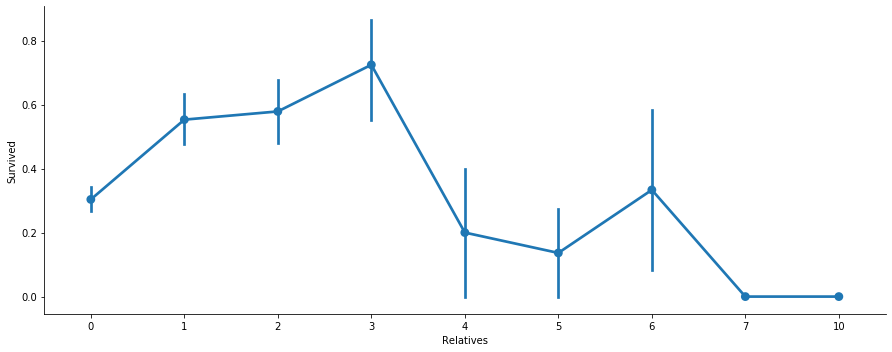

In [141]:
sns.factorplot('Relatives','Survived', data=train_df, aspect = 2.5)

Graph representing survival given a number of relatives you have on board. Having up to 3 relatives increases your chances of survival, having more relatives, decreases.

In [142]:
# Possible to add another Related field family size for instance as top but + 1
# size of families (including the passenger)
 #titanic['FamilySize'] = titanic.Parch + titanic.SibSp + 1

## Titles 
working with titles to divide them into title matching groups

In [143]:
# create a new feature to extract title names from the Name column
for dataset in data:
    dataset['Title'] = dataset['Name'].apply(lambda name: name.split(',')[1].split('.')[0].strip())

In [144]:
train_df['Title'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Col               2
Major             2
Mlle              2
Don               1
Capt              1
Ms                1
the Countess      1
Mme               1
Jonkheer          1
Sir               1
Lady              1
Name: Title, dtype: int64

In [145]:
# normalize the titles
normalized_titles = {
    "Capt":       "Personnel",
    "Col":        "Personnel",
    "Major":      "Personnel",
    "Jonkheer":   "Royalty",
    "Don":        "Royalty",
    "Sir" :       "Royalty",
    "Dr":         "Dr",
    "Rev":        "Personnel",
    "the Countess":"Royalty",
    "Dona":       "Royalty",
    "Mme":        "Mrs",
    "Mlle":       "Miss",
    "Ms":         "Mrs",
    "Mr" :        "Mr",
    "Mrs" :       "Mrs",
    "Miss" :      "Miss",
    "Master" :    "Mr",
    "Lady" :      "Royalty"
}

for dataset in data:
     # map the normalized titles to the current titles 
    dataset.Title = dataset.Title.map(normalized_titles)
    
# view value counts for the normalized titles
print(train_df.Title.value_counts())

Mr           557
Miss         184
Mrs          127
Personnel     11
Dr             7
Royalty        5
Name: Title, dtype: int64


## Age
Using groupby of different titles, genders and ticket class to predict mediat Age of persons - which later can be used to assign Ages to missing persons

In [146]:
#merge train and test datasets
age_prediction_df = pd.concat([train_df, test_df], ignore_index=True, sort=True)

# group by Sex, Pclass, and Title 
grouped = age_prediction_df.groupby(['Sex','Pclass', 'Title'])  
grouped.Age.median()

Sex     Pclass  Title    
female  1       Dr           49.0
                Miss         30.0
                Mrs          45.0
                Royalty      39.0
        2       Miss         20.0
                Mrs          30.0
        3       Miss         18.0
                Mrs          31.0
male    1       Dr           47.0
                Mr           40.0
                Personnel    53.0
                Royalty      40.0
        2       Dr           38.5
                Mr           29.0
                Personnel    41.5
        3       Mr           25.0
Name: Age, dtype: float64

In [147]:
# apply the grouped median value on the Age NaN
for dataset in data:
    dataset.Age = grouped.Age.apply(lambda x: x.fillna(x.median()))

train_df.Age.describe()

count    891.000000
mean      29.142727
std       13.461366
min        0.420000
25%       21.000000
50%       26.000000
75%       36.750000
max       80.000000
Name: Age, dtype: float64

## Cabin

Letter in front of a cabin represents some sort of section or a deck on the ship, therefore keeping only letters makes most sense in our case. Removing numbers.

In [148]:
# Option 1: map first letter of cabin to itself
for dataset in data:
    dataset.Cabin = dataset.Cabin.map(lambda x: x[0])
    
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Relatives,Alone,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,U,S,1,0,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C,1,0,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,U,S,0,1,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S,1,0,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,U,S,0,1,Mr


## Age Group

In [149]:
# Possibility to add age group - would it predict better?
data = [train_df, test_df]

for dataset in data:
    dataset.loc[dataset['Age'] <= 11, 'Age Group'] = 0
    dataset.loc[(dataset['Age'] > 11) & (dataset['Age'] <= 18), 'Age Group'] = 1
    dataset.loc[(dataset['Age'] > 18) & (dataset['Age'] <= 22), 'Age Group'] = 2
    dataset.loc[(dataset['Age'] > 22) & (dataset['Age'] <= 27), 'Age Group'] = 3
    dataset.loc[(dataset['Age'] > 27) & (dataset['Age'] <= 33), 'Age Group'] = 4
    dataset.loc[(dataset['Age'] > 33) & (dataset['Age'] <= 40), 'Age Group'] = 5
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 66), 'Age Group'] = 6
    dataset.loc[ dataset['Age'] > 66, 'Age Group'] = 6
    dataset['Age Group'] = dataset['Age Group'].astype(int)


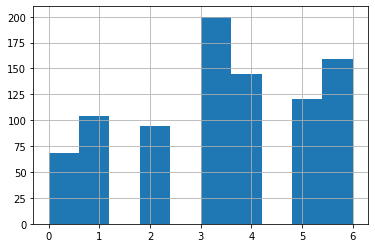

In [150]:
train_df['Age Group'].hist()

## Data Preprocessing

In [151]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Relatives,Alone,Title,Age Group
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,U,S,1,0,Mr,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C,1,0,Mrs,5
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,U,S,0,1,Miss,3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S,1,0,Mrs,5
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,U,S,0,1,Mr,5


In [152]:
#Drop names
train_df = train_df.drop(['Name'], axis=1)
test_df = test_df.drop(['Name'], axis=1)

#Drop Ticket numbers
train_df = train_df.drop(['Ticket'], axis=1)
test_df = test_df.drop(['Ticket'], axis=1)

In [153]:
#Age - turn it into integer
data = [train_df, test_df]

for dataset in data:
    dataset["Age"] = dataset["Age"].astype(int)

In [154]:
#Fare - Encode as integer
data = [train_df, test_df]

for dataset in data:
    dataset['Fare'] = dataset['Fare'].astype(int)

In [155]:
train_df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Relatives,Alone,Title,Age Group
0,1,0,3,male,22,1,0,7,U,S,1,0,Mr,2
1,2,1,1,female,38,1,0,71,C,C,1,0,Mrs,5
2,3,1,3,female,26,0,0,7,U,S,0,1,Miss,3
3,4,1,1,female,35,1,0,53,C,S,1,0,Mrs,5
4,5,0,3,male,35,0,0,8,U,S,0,1,Mr,5


## One hot encoding

In [156]:
# Get one hot encoding of columns 
sex = pd.get_dummies(train_df['Sex'])
cabin = pd.get_dummies(train_df['Cabin'])
embarked = pd.get_dummies(train_df['Embarked'])
title = pd.get_dummies(train_df['Title'])
pclass = pd.get_dummies(train_df['Pclass'])

# Drop column B as it is now encoded
train_df = train_df.drop('Sex',axis = 1)
train_df = train_df.drop('Cabin',axis = 1)
train_df = train_df.drop('Embarked',axis = 1)
train_df = train_df.drop('Title',axis = 1)
train_df = train_df.drop('Pclass',axis = 1)

# Join the encoded df
train_df = train_df.join(sex)
train_df = train_df.join(cabin, lsuffix='Cabin')
train_df = train_df.join(embarked, lsuffix='Embarked')
train_df = train_df.join(title)
train_df = train_df.join(pclass,lsuffix='Pclass')

In [157]:
train_df.head() 

,PassengerId,Survived,Age,SibSp,Parch,Fare,Relatives,Alone,Age Group,female,male,A,B,CEmbarked,D,E,F,G,T,U,C,Q,S,Dr,Miss,Mr,Mrs,Personnel,Royalty,1,2,3
0,1,0,22,1,0,7,1,0,2,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1
1,2,1,38,1,0,71,1,0,5,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0
2,3,1,26,0,0,7,0,1,3,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1
3,4,1,35,1,0,53,1,0,5,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0
4,5,0,35,0,0,8,0,1,5,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1


In [158]:
# Get one hot encoding of columns 
sex = pd.get_dummies(test_df['Sex'])
cabin = pd.get_dummies(test_df['Cabin'])
embarked = pd.get_dummies(test_df['Embarked'])
title = pd.get_dummies(test_df['Title'])
pclass = pd.get_dummies(test_df['Pclass'])

# Drop column B as it is now encoded
test_df = test_df.drop('Sex',axis = 1)
test_df = test_df.drop('Cabin',axis = 1)
test_df = test_df.drop('Embarked',axis = 1)
test_df = test_df.drop('Title',axis = 1)
test_df = test_df.drop('Pclass',axis = 1)

# Join the encoded df
test_df = test_df.join(sex)
test_df = test_df.join(cabin, lsuffix='Cabin')
test_df = test_df.join(embarked, lsuffix='Embarked')
test_df = test_df.join(title)
test_df = test_df.join(pclass,lsuffix='pclass')
test_df.head() 

,PassengerId,Age,SibSp,Parch,Fare,Survived,Relatives,Alone,Age Group,female,male,A,B,CEmbarked,D,E,F,G,U,C,Q,S,Dr,Miss,Mr,Mrs,Personnel,Royalty,1,2,3
0,892,22,0,0,7,0,0,1,2,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1
1,893,38,1,0,7,1,1,0,5,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1
2,894,26,0,0,9,0,0,1,3,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0
3,895,35,0,0,8,0,0,1,5,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1
4,896,35,1,1,12,1,2,0,5,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1


In [159]:
test_df['T'] = 0

In [160]:
test_df.head() 

,PassengerId,Age,SibSp,Parch,Fare,Survived,Relatives,Alone,Age Group,female,male,A,B,CEmbarked,D,E,F,G,U,C,Q,S,Dr,Miss,Mr,Mrs,Personnel,Royalty,1,2,3,T
0,892,22,0,0,7,0,0,1,2,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0
1,893,38,1,0,7,1,1,0,5,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0
2,894,26,0,0,9,0,0,1,3,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0
3,895,35,0,0,8,0,0,1,5,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0
4,896,35,1,1,12,1,2,0,5,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0


## Scalling

In [424]:
from sklearn.preprocessing import StandardScaler

scaled_train = train_df.copy()
scaled_test = test_df.copy()

col_names = ['Age', 'Weight']
features = scaled_features[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

## Specify Prediction Target


In [161]:
#Survived is a prediction data
target = 'Survived'

In [162]:
train_df.columns

Index(['PassengerId',    'Survived',         'Age',       'SibSp',
             'Parch',        'Fare',   'Relatives',       'Alone',
         'Age Group',      'female',        'male',           'A',
                 'B',   'CEmbarked',           'D',           'E',
                 'F',           'G',           'T',           'U',
                 'C',           'Q',           'S',          'Dr',
              'Miss',          'Mr',         'Mrs',   'Personnel',
           'Royalty',             1,             2,             3],
      dtype='object')

## Specify features

In [163]:
features = ['Age', 'SibSp','Parch','Fare', 'Relatives', 'Alone','Age Group',
            'female','male','A','B','CEmbarked','D','E','F','G','T','U','C',
            'Q','S','Dr','Miss','Mr','Mrs','Personnel','Royalty',1, 2,3]  

## Split into validation and training data


In [52]:
from sklearn.model_selection import train_test_split

train_X, val_X, train_y, val_y = train_test_split(train_df[features], train_df[target], test_size = 0.01)

## Specify and Fit Model

In [53]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

dtm = DecisionTreeClassifier()
rtm = RandomForestClassifier(n_estimators = 100 , n_jobs = -1)
mlp = MLPClassifier()
knn = KNeighborsClassifier(3)
svm = SVC()
gau = GaussianProcessClassifier()
ada = AdaBoostClassifier()
gaunb = GaussianNB()

In [164]:
%time dtm.fit(train_df[features],train_df[target])
%time rtm.fit(train_df[features],train_df[target])
%time mlp.fit(train_df[features],train_df[target])
%time knn.fit(train_df[features],train_df[target])
%time svm.fit(train_df[features],train_df[target])
%time gau.fit(train_df[features],train_df[target])
%time ada.fit(train_df[features],train_df[target])
%time gaunb.fit(train_df[features],train_df[target])

Wall time: 4.01 ms
Wall time: 129 ms


c:\users\val\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\val\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Wall time: 765 ms
Wall time: 2.01 ms
Wall time: 31.1 ms
Wall time: 432 ms
Wall time: 62.2 ms
Wall time: 2.01 ms


GaussianNB(priors=None, var_smoothing=1e-09)

In [166]:
def print_scores():
    print('Decision Tress:',dtm.score(test_df[features],test_df[target]))
    print('Random Forest:', rtm.score(test_df[features],test_df[target]))
    print('MLPClassifier:', mlp.score(test_df[features],test_df[target]))
    print('KNeighborsClassifier:', knn.score(test_df[features],test_df[target]))
    print('SVC:', svm.score(test_df[features],test_df[target])) 
    print('GaussianProcessClassifier:',gau.score(test_df[features],test_df[target]))  
    print('AdaBoostClassifier:',ada.score(test_df[features],test_df[target]))
    print('GaussianNB:',gaunb.score(test_df[features],test_df[target]))

print_scores()    

Decision Tress: 0.6555023923444976
Random Forest: 0.6866028708133971
MLPClassifier: 0.7200956937799043
KNeighborsClassifier: 0.6220095693779905
SVC: 0.6411483253588517
GaussianProcessClassifier: 0.6435406698564593
AdaBoostClassifier: 0.715311004784689
GaussianNB: 0.7320574162679426


### Model 2 (Feature importance)

In [510]:
importances = rtm.feature_importances_

Feature ranking:
Age 1. feature 0 (0.183008)
SibSp 2. feature 3 (0.170657)
Parch 3. feature 7 (0.089078)
Fare 4. feature 8 (0.077105)
Relatives 5. feature 6 (0.070609)
Alone 6. feature 4 (0.056271)
Age Group 7. feature 29 (0.039045)
female 8. feature 1 (0.035425)
male 9. feature 23 (0.034985)
A 10. feature 17 (0.033805)
B 11. feature 2 (0.032721)
CEmbarked 12. feature 22 (0.023547)
D 13. feature 28 (0.023046)
E 14. feature 30 (0.021700)
F 15. feature 20 (0.014855)
G 16. feature 24 (0.013951)
T 17. feature 18 (0.013258)
U 18. feature 5 (0.009905)
C 19. feature 13 (0.009173)
Q 20. feature 19 (0.008840)
S 21. feature 11 (0.008801)
DrPclass 22. feature 10 (0.007442)
MissPclass 23. feature 12 (0.007409)
MrPclass 24. feature 9 (0.003243)
MrsPclass 25. feature 15 (0.003200)
PersonnelPclass 26. feature 31 (0.002316)
RoyaltyPclass 27. feature 25 (0.001787)
Dr 28. feature 14 (0.001487)
Miss 29. feature 27 (0.001450)
Mr 30. feature 21 (0.001220)
Mrs 31. feature 16 (0.000318)
Personnel 32. feature

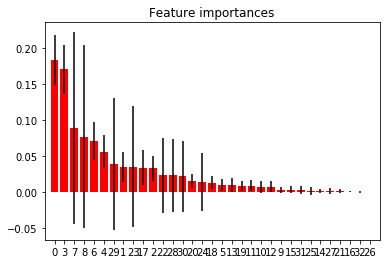

In [511]:
std = np.std([tree.feature_importances_ for tree in rtm.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")


for f in range(train_df[features].shape[1]):
    print(features[f],"%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(train_df[features].shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(train_df[features].shape[1]), indices)
plt.xlim([-1, train_df[features].shape[1]])
plt.show()

In [403]:
top10_features = ['Pclass','Age','SibSp','Parch','Fare','Relatives','Alone','Age Group','female','male']
train_X, val_X, train_y, val_y = train_test_split(train_df[top10_features], train_df[target], test_size = 0.01)

In [410]:
rtm2 = RandomForestClassifier(n_estimators = 100 , n_jobs = -1)
rtm2.fit(train_df[top10_features],train_df[target])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [405]:
rtm2.score(val_X,val_y)

0.8340807174887892

Feature ranking:
Pclass 1. feature 1 (0.210896)
Age 2. feature 4 (0.206135)
SibSp 3. feature 9 (0.171895)
Parch 4. feature 8 (0.142549)
Fare 5. feature 0 (0.079292)
Relatives 6. feature 7 (0.064793)
Alone 7. feature 5 (0.061056)
Age Group 8. feature 2 (0.031493)
female 9. feature 3 (0.022147)
male 10. feature 6 (0.009745)


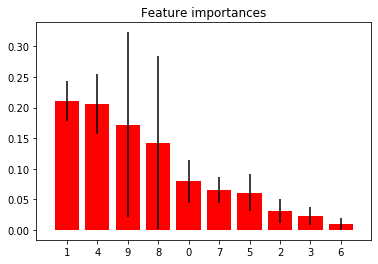

In [406]:
importances = rtm2.feature_importances_
std = np.std([tree.feature_importances_ for tree in rtm2.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")


for f in range(train_df[top10_features].shape[1]):
    print(features[f],"%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(train_df[top10_features].shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(train_df[top10_features].shape[1]), indices)
plt.xlim([-1, train_df[top10_features].shape[1]])
plt.show()

In [391]:
### Model 3

In [399]:
top7_features = ['Pclass','Age','SibSp','Parch','Fare','Relatives', 'Alone'] 

In [400]:
train_X, val_X, train_y, val_y = train_test_split(train_df[top7_features], train_df[target], test_size = 0.25)

In [401]:
rtm3 = RandomForestClassifier(n_estimators = 100 , n_jobs = -1)
rtm3.fit(train_X,train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [402]:
rtm3.score(val_X,val_y)

0.6771300448430493

## Gridsearch - finding best params

In [249]:
# create param grid object 
from math import sqrt, log2

forrest_params = dict(     
    max_depth = [None],     
    min_samples_split = [2, 5, 10],
    min_samples_leaf = [1,3,5,10,25],     
    n_estimators = [100],
    max_features = ['auto', 'sqrt'],
    n_jobs = [-1])

In [250]:
# build and fit model 
forest_cv = GridSearchCV(estimator=rtm,     param_grid=forrest_params, cv=5) 
%time forest_cv.fit(train_X, train_y)

KeyboardInterrupt: 

In [295]:
print("Best score: {}".format(forest_cv.best_score_))
print("Optimal params: {}".format(forest_cv.best_estimator_))

Best score: 0.8269484808454426
Optimal params: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)


## Predict on test data & save as .csv file

In [168]:
X_test = test_df[features]

In [174]:
forrest_predictions = gaunb.predict(test_df[features])

In [175]:
# dataframe with predictions
kaggle = pd.DataFrame({'PassengerId': passengerId, 'Survived': forrest_predictions})

# save to csv
kaggle.to_csv('titanic_gausian.csv', index=False)